In [3]:
# --- 1. C√†i ƒë·∫∑t & Th∆∞ vi·ªán ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os

# Th∆∞ vi·ªán Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Th∆∞ vi·ªán XGBoost
import xgboost as xgb

# C√†i ƒë·∫∑t chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
# --- 2. T·∫£i v√† Chu·∫©n b·ªã D·ªØ li·ªáu ---
try:
    # T·∫£i d·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c feature engineering
    df = pd.read_csv('clean_student_data_v1.csv')
    print("T·∫£i d·ªØ li·ªáu t·ª´ 'clean_student_data_v1.csv' th√†nh c√¥ng.")
    TARGET_COLUMN = ['weekly_study_hours','attendance_percentage']
    df['raw_score_x_part_time_hours'] = df['raw_score'] * df['part_time_hours']
    df['raw_score_x_financial_support'] = df['raw_score'] * df['financial_support']
    df['raw_score_x_emotional_support'] = df['raw_score'] * df['emotional_support']
    df['raw_score_x_part_time_financial'] = df['raw_score'] * df['part_time_hours'] * df['financial_support']
    DROP_COLUMNS = [
        'weekly_study_hours','attendance_percentage',
        'study_hours_x_attendance',
        'full_interaction_feature',
        'expected_score_hint',
        'student_id', 'year',
        'cumulative_gpa', 'current_semester_gpa',
        'previous_courses_taken', 'previous_credits_earned',
        'expected_difficulty', 'subject_type','fail_rate_general','fail_rate_major','study_hours_x_part_part_time_hours',
        'attendance_x_emotional_support'
    ]
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]

    # Chia t·∫≠p train/test tr∆∞·ªõc khi x·ª≠ l√Ω ƒë·ªÉ tr√°nh data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- 3. X√¢y d·ª±ng Pipeline x·ª≠ l√Ω ho√†n ch·ªânh (bao g·ªìm c·∫£ Scaling) ---
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train.select_dtypes(include=np.number).columns
    
    # T·∫°o c√°c b∆∞·ªõc x·ª≠ l√Ω
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler() # Chu·∫©n h√≥a c√°c ƒë·∫∑c tr∆∞ng s·ªë
    
    # K·∫øt h·ª£p c√°c b∆∞·ªõc x·ª≠ l√Ω b·∫±ng ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    
    # T·∫°o pipeline ch·ªâ ch·ª©a b∆∞·ªõc ti·ªÅn x·ª≠ l√Ω
    preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Fit pipeline tr√™n t·∫≠p train v√† bi·∫øn ƒë·ªïi c·∫£ 2 t·∫≠p
    X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
    X_test_transformed = preprocessing_pipeline.transform(X_test)
    
    # L·∫•y t√™n c√°c ƒë·∫∑c tr∆∞ng sau khi ƒë√£ bi·∫øn ƒë·ªïi
    feature_names = preprocessing_pipeline.named_steps['preprocessor'].get_feature_names_out()

    print(f"D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a v√† s·∫µn s√†ng. K√≠ch th∆∞·ªõc X_train_transformed: {X_train_transformed.shape}")

except FileNotFoundError:
    print("L·ªói: Kh√¥ng t√¨m th·∫•y file 'clean_student_data_v1.csv'.")
    X_train_transformed = None

T·∫£i d·ªØ li·ªáu t·ª´ 'clean_student_data_v1.csv' th√†nh c√¥ng.
D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a v√† s·∫µn s√†ng. K√≠ch th∆∞·ªõc X_train_transformed: (272000, 74)


In [4]:
# Hu·∫•n luy·ªán pipeline tr√™n d·ªØ li·ªáu training
print("ƒêang hu·∫•n luy·ªán pipeline tr√™n X_train...")
preprocessing_pipeline.fit(X_train)
print("Hu·∫•n luy·ªán ho√†n t·∫•t.")

# L∆∞u pipeline ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán ra file joblib
pipeline_filename = 'preprocessing_pipeline_reverse_2_8_2025_1.joblib'
joblib.dump(preprocessing_pipeline, pipeline_filename)

print(f"\nTo√†n b·ªô pipeline ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh c√¥ng v√†o file: '{pipeline_filename}'")
display(preprocessing_pipeline)

ƒêang hu·∫•n luy·ªán pipeline tr√™n X_train...
Hu·∫•n luy·ªán ho√†n t·∫•t.

To√†n b·ªô pipeline ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh c√¥ng v√†o file: 'preprocessing_pipeline_reverse_2_8_2025_1.joblib'


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['course_code', 'study_format'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['semester_number', 'credits_unit', 'raw_score', 'part_time_hours',
       'financial_support', 'emotional_support',
       'financial_support_x_part_time_hours', 'raw_score_x_part_time_hours',
       'raw_score_x_financial_support', 'raw_score_x_emotional_support',
       'raw_score_x_part_time_financial'],
      dtype='object'))]))])

In [3]:
#t√°i s·ª≠ d·ª•ng l·∫°i
# Gi·∫£ s·ª≠ ƒë√¢y l√† m·ªôt script kh√°c ho·∫∑c m·ªôt l·∫ßn ch·∫°y sau
print("--- Th·ª≠ nghi·ªám n·∫°p v√† s·ª≠ d·ª•ng l·∫°i pipeline ---")

# T·∫£i pipeline t·ª´ file
loaded_pipeline = joblib.load(pipeline_filename)
print("ƒê√£ t·∫£i pipeline t·ª´ file.")

# S·ª≠ d·ª•ng pipeline ƒë√£ t·∫£i ƒë·ªÉ bi·∫øn ƒë·ªïi d·ªØ li·ªáu test
# D·ªØ li·ªáu test s·∫Ω ƒë∆∞·ª£c bi·∫øn ƒë·ªïi theo ƒë√∫ng c√°ch m√† d·ªØ li·ªáu train ƒë√£ ƒë∆∞·ª£c h·ªçc
X_test_transformed = loaded_pipeline.transform(X_test)

print(f"\nK√≠ch th∆∞·ªõc c·ªßa X_test g·ªëc: {X_test.shape}")
print(f"K√≠ch th∆∞·ªõc c·ªßa X_test sau khi bi·∫øn ƒë·ªïi qua pipeline: {X_test_transformed.shape}")
print("Bi·∫øn ƒë·ªïi th√†nh c√¥ng! D·ªØ li·ªáu ƒë√£ s·∫µn s√†ng ƒë·ªÉ ƒë∆∞a v√†o m√¥ h√¨nh.")

--- Th·ª≠ nghi·ªám n·∫°p v√† s·ª≠ d·ª•ng l·∫°i pipeline ---
ƒê√£ t·∫£i pipeline t·ª´ file.

K√≠ch th∆∞·ªõc c·ªßa X_test g·ªëc: (67000, 10)
K√≠ch th∆∞·ªõc c·ªßa X_test sau khi bi·∫øn ƒë·ªïi qua pipeline: (67000, 71)
Bi·∫øn ƒë·ªïi th√†nh c√¥ng! D·ªØ li·ªáu ƒë√£ s·∫µn s√†ng ƒë·ªÉ ƒë∆∞a v√†o m√¥ h√¨nh.


In [4]:
# === PH·∫¶N 0: C√ÄI ƒê·∫∂T & TH∆Ø VI·ªÜN ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import joblib
# Th∆∞ vi·ªán Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Th∆∞ vi·ªán XGBoost
import xgboost as xgb

# C√†i ƒë·∫∑t chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'


# === PH·∫¶N 1: T·∫¢I V√Ä TI·ªÄN X·ª¨ L√ù D·ªÆ LI·ªÜU ===
data_loaded_successfully = False
try:
    df = pd.read_csv('clean_student_data_v1.csv')
    print("T·∫£i d·ªØ li·ªáu t·ª´ 'clean_student_data_v1.csv' th√†nh c√¥ng.")
    TARGET_COLUMN = 'weekly_study_hours'
    DROP_COLUMNS = [
    'weekly_study_hours',
    'study_hours_x_attendance',
    'full_interaction_feature',
    'expected_score_hint',
    'student_id', 'year',
    'cumulative_gpa', 'current_semester_gpa',
    'previous_courses_taken', 'previous_credits_earned',
    'expected_difficulty', 'subject_type','fail_rate_general','fail_rate_major','study_hours_x_part_part_time_hours'
    ]
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"ƒê√£ chia d·ªØ li·ªáu: {X_train_raw.shape[0]} m·∫´u hu·∫•n luy·ªán, {X_test_raw.shape[0]} m·∫´u ki·ªÉm tra.")
    
    categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train_raw.select_dtypes(include=np.number).columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)
    feature_names = preprocessor.get_feature_names_out()
    print(f"D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c m√£ h√≥a v√† chu·∫©n h√≥a. K√≠ch th∆∞·ªõc X_train m·ªõi: {X_train.shape}")
    data_loaded_successfully = True

except FileNotFoundError:
    print("\nL·ªñI: Kh√¥ng t√¨m th·∫•y file 'clean_student_data_v1.csv'.\n")

# === TO√ÄN B·ªò QUY TR√åNH HU·∫§N LUY·ªÜN CH·ªà CH·∫†Y KHI D·ªÆ LI·ªÜU T·∫¢I TH√ÄNH C√îNG ===
if data_loaded_successfully:
    # === PH·∫¶N 2: C·∫¢I TI·∫æN V√Ä HU·∫§N LUY·ªÜN M√î H√åNH ===
    print("\n---B·∫Øt ƒë·∫ßu t·ªëi ∆∞u m√¥ h√¨nh XGBoost ---")
    param_grid_xgb = {
        'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 10, 100]
    }
    xgb_model_base = xgb.XGBRegressor(
        objective='reg:squarederror', learning_rate=0.05, max_depth=5,
        random_state=42, n_jobs=-1, n_estimators=500
    )
    grid_search_xgb = GridSearchCV(
        estimator=xgb_model_base, param_grid=param_grid_xgb, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_xgb.fit(X_train, y_train)
    print(f"\nC√°c tham s·ªë XGBoost t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c: {grid_search_xgb.best_params_}")
    
    print("--- Hu·∫•n luy·ªán m√¥ h√¨nh XGBoost cu·ªëi c√πng v·ªõi Early Stopping ---")
    best_xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, random_state=42, n_jobs=-1,
        early_stopping_rounds=20, **grid_search_xgb.best_params_
    )
    best_xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    print("\n---B·∫Øt ƒë·∫ßu t·ªëi ∆∞u m√¥ h√¨nh MLPRegressor ---")
    param_grid_mlp = {
        'hidden_layer_sizes': [(128,), (128, 64), (256, 128, 64)],
        'solver': ['adam'], 'learning_rate_init': [0.001, 0.01], 'alpha': [0.0001, 0.001]
    }
    mlp_model_base = MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)
    grid_search_mlp = GridSearchCV(
        estimator=mlp_model_base, param_grid=param_grid_mlp, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_mlp.fit(X_train, y_train)
    best_mlp_model = grid_search_mlp.best_estimator_
    print(f"\nC√°c tham s·ªë MLPRegressor t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c: {grid_search_mlp.best_params_}")

    # === PH·∫¶N 3: ƒê√ÅNH GI√Å ƒê·ªò CH√çNH X√ÅC SAU T·ªêI ∆ØU ===
    print("\n--- ƒê√°nh gi√° ƒë·ªô ch√≠nh x√°c tr√™n t·∫≠p Test ---")
    trained_models = {
        "XGBoost T·ªëi ∆∞u": best_xgb_model, "MLPRegressor T·ªëi ∆∞u": best_mlp_model
    }
    evaluation_results = []
    for model_name, model in trained_models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        
        # S·ª¨A L·ªñI: Thay th·∫ø c√°ch t√≠nh RMSE ƒë·ªÉ t∆∞∆°ng th√≠ch v·ªõi m·ªçi phi√™n b·∫£n sklearn
        # D√≤ng m√£ c≈©: rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        r2 = r2_score(y_test, y_pred)
        evaluation_results.append({"M√¥ h√¨nh": model_name, "MAE": mae, "RMSE": rmse, "R¬≤ Score": r2})
        print(f"K·∫øt qu·∫£ cho {model_name}:\n  - MAE: {mae:.4f}\n  - RMSE: {rmse:.4f}\n  - R¬≤ Score: {r2:.4f}\n")
    eval_df = pd.DataFrame(evaluation_results)

T·∫£i d·ªØ li·ªáu t·ª´ 'clean_student_data_v1.csv' th√†nh c√¥ng.
ƒê√£ chia d·ªØ li·ªáu: 268000 m·∫´u hu·∫•n luy·ªán, 67000 m·∫´u ki·ªÉm tra.
D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c m√£ h√≥a v√† chu·∫©n h√≥a. K√≠ch th∆∞·ªõc X_train m·ªõi: (268000, 71)

---B·∫Øt ƒë·∫ßu t·ªëi ∆∞u m√¥ h√¨nh XGBoost ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits

C√°c tham s·ªë XGBoost t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c: {'colsample_bytree': 1.0, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 0.8}
--- Hu·∫•n luy·ªán m√¥ h√¨nh XGBoost cu·ªëi c√πng v·ªõi Early Stopping ---

---B·∫Øt ƒë·∫ßu t·ªëi ∆∞u m√¥ h√¨nh MLPRegressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

C√°c tham s·ªë MLPRegressor t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c: {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.01, 'solver': 'adam'}

--- ƒê√°nh gi√° ƒë·ªô ch√≠nh x√°c tr√™n t·∫≠p Test ---
K·∫øt qu·∫£ cho XGBoost T·ªëi ∆∞u:
  - MAE: 3.7926
  - RMSE: 4.9074
  - R¬≤ Score: 0.6835

K·∫øt qu·∫£ cho MLPRegress

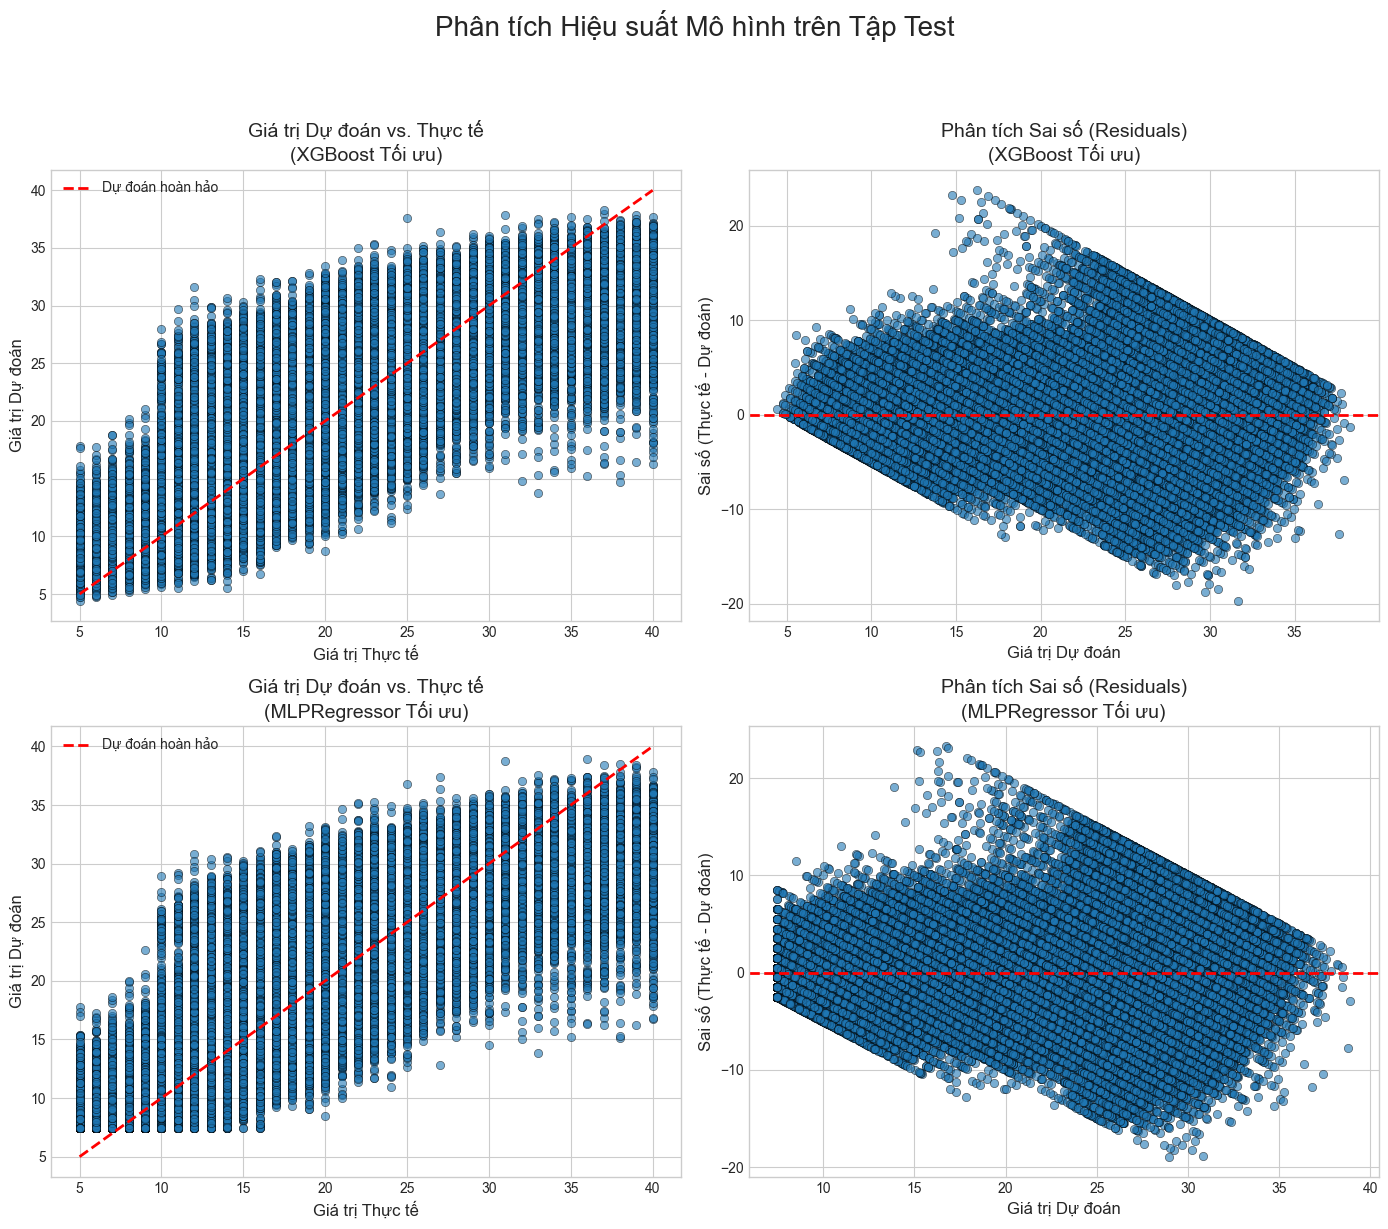

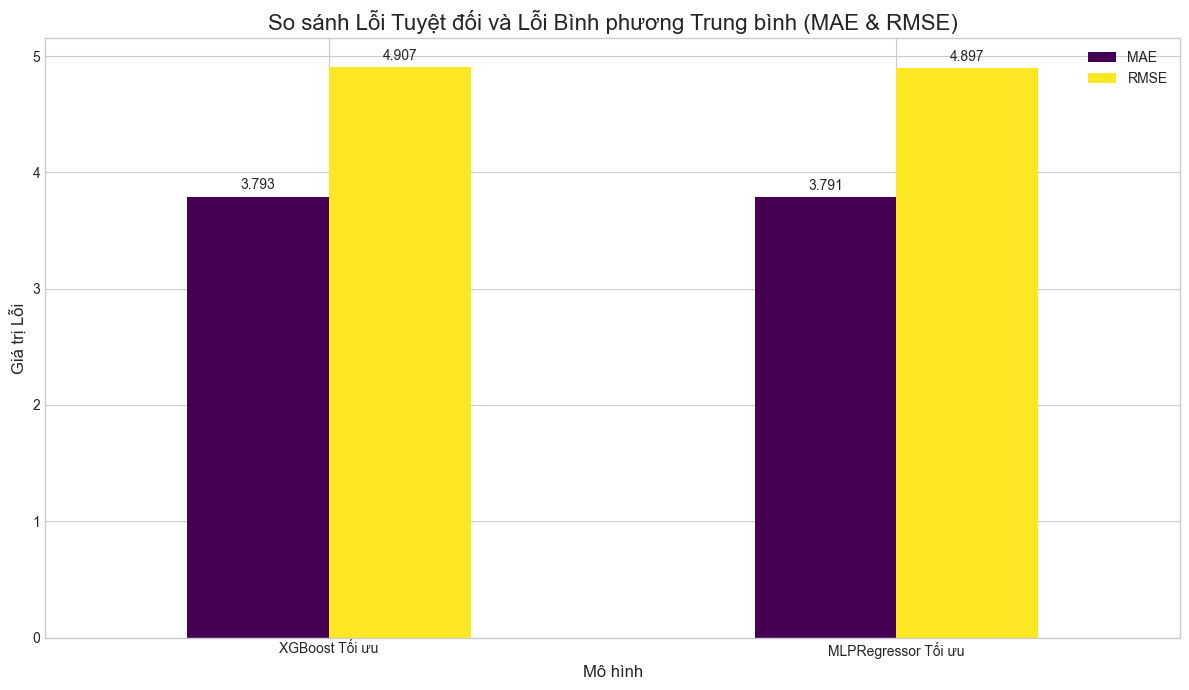

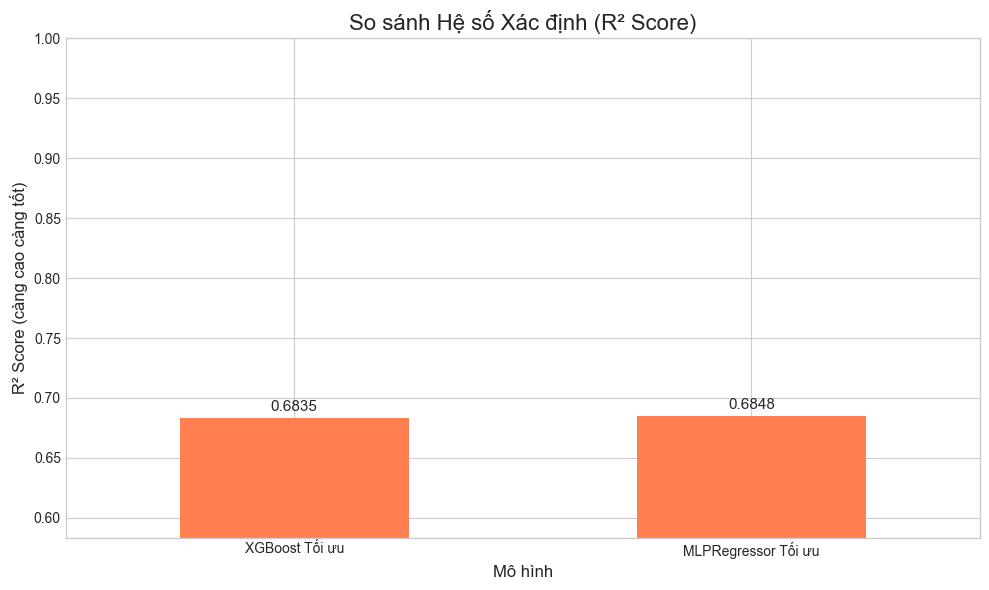


---B·∫£ng t·ªïng k·∫øt so s√°nh hi·ªáu su·∫•t ---


In [6]:
    # === PH·∫¶N 4: BI·ªÇU DI·ªÑN K·∫æT QU·∫¢ TR·ª∞C QUAN ===
    # (Ph·∫ßn n√†y kh√¥ng thay ƒë·ªïi, gi·ªØ nguy√™n nh∆∞ c≈©)
    n_models = len(trained_models)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 6 * n_models), squeeze=False)
    fig.suptitle('Ph√¢n t√≠ch Hi·ªáu su·∫•t M√¥ h√¨nh tr√™n T·∫≠p Test', fontsize=20, y=1.02)
    for i, (model_name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        ax_scatter = axes[i, 0]
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax_scatter, edgecolor='k')
        perfect_line = np.linspace(min(y_test), max(y_test), 100)
        ax_scatter.plot(perfect_line, perfect_line, 'r--', lw=2, label='D·ª± ƒëo√°n ho√†n h·∫£o')
        ax_scatter.set_title(f'Gi√° tr·ªã D·ª± ƒëo√°n vs. Th·ª±c t·∫ø\n({model_name})', fontsize=14)
        ax_scatter.set_xlabel('Gi√° tr·ªã Th·ª±c t·∫ø', fontsize=12)
        ax_scatter.set_ylabel('Gi√° tr·ªã D·ª± ƒëo√°n', fontsize=12)
        ax_scatter.legend()
        ax_scatter.grid(True)
        ax_residual = axes[i, 1]
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=ax_residual, edgecolor='k')
        ax_residual.axhline(y=0, color='r', linestyle='--', lw=2)
        ax_residual.set_title(f'Ph√¢n t√≠ch Sai s·ªë (Residuals)\n({model_name})', fontsize=14)
        ax_residual.set_xlabel('Gi√° tr·ªã D·ª± ƒëo√°n', fontsize=12)
        ax_residual.set_ylabel('Sai s·ªë (Th·ª±c t·∫ø - D·ª± ƒëo√°n)', fontsize=12)
        ax_residual.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    eval_df.set_index('M√¥ h√¨nh', inplace=True)
    ax1 = eval_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 7), rot=0, colormap='viridis')
    ax1.set_title('So s√°nh L·ªói Tuy·ªát ƒë·ªëi v√† L·ªói B√¨nh ph∆∞∆°ng Trung b√¨nh (MAE & RMSE)', fontsize=16)
    ax1.set_ylabel('Gi√° tr·ªã L·ªói', fontsize=12)
    ax1.set_xlabel('M√¥ h√¨nh', fontsize=12)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

    ax2 = eval_df[['R¬≤ Score']].plot(kind='bar', figsize=(10, 6), rot=0, color='coral', legend=False)
    ax2.set_title('So s√°nh H·ªá s·ªë X√°c ƒë·ªãnh (R¬≤ Score)', fontsize=16)
    ax2.set_ylabel('R¬≤ Score (c√†ng cao c√†ng t·ªët)', fontsize=12)
    ax2.set_xlabel('M√¥ h√¨nh', fontsize=12)
    ax2.set_ylim(bottom=max(0, eval_df['R¬≤ Score'].min() - 0.1), top=1.0)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.4f', fontsize=11, padding=3)
    plt.tight_layout()
    plt.show()

    # === PH·∫¶N 5: HI·ªÇN TH·ªä B·∫¢NG SO S√ÅNH CU·ªêI C√ôNG ===
    print("\n---B·∫£ng t·ªïng k·∫øt so s√°nh hi·ªáu su·∫•t ---")
    display(eval_df.style.format("{:.4f}").highlight_min(
        subset=['MAE', 'RMSE'], color='#c8e6c9'
    ).highlight_max(
        subset=['R¬≤ Score'], color='#c8e6c9'
    ))

In [7]:
# ===================================================================
# === PH·∫¶N 6: L∆ØU V√Ä KI·ªÇM TRA PIPELINE HO√ÄN CH·ªàNH                 ===
# ===================================================================
print("\n--- üíæ B·∫Øt ƒë·∫ßu l∆∞u v√† ki·ªÉm tra pipeline ho√†n ch·ªânh ---")

    # --- 6.1. K·∫øt h·ª£p preprocessor v√† model th√†nh m·ªôt pipeline duy nh·∫•t ---
    # `preprocessor` l√† ƒë·ªëi t∆∞·ª£ng ColumnTransformer ƒë√£ ƒë∆∞·ª£c fit ·ªü Ph·∫ßn 1
    # `best_xgb_model` v√† `best_mlp_model` l√† c√°c m√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán ·ªü Ph·∫ßn 2
    
print("   -> ƒêang t·∫°o c√°c pipeline ho√†n ch·ªânh (preprocessor + model)...")
xgb_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb_model)
])

mlp_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_mlp_model)
])
print("   -> T·∫°o pipeline ho√†n ch·ªânh th√†nh c√¥ng.")

# --- 6.2. L∆∞u c√°c pipeline ho√†n ch·ªânh v√†o file .joblib ---
xgb_filename = "xgb_final_pipeline_revese.joblib"
mlp_filename = "mlp_final_pipeline_revese.joblib"

joblib.dump(xgb_full_pipeline, xgb_filename)
print(f"   -> ƒê√£ l∆∞u pipeline XGBoost v√†o file: '{xgb_filename}'")
    
joblib.dump(mlp_full_pipeline, mlp_filename)
print(f"   -> ƒê√£ l∆∞u pipeline MLPRegressor v√†o file: '{mlp_filename}'")

# --- 6.3. Ki·ªÉm tra l·∫°i c√°c file ƒë√£ l∆∞u ƒë·ªÉ ƒë·∫£m b·∫£o t√≠nh to√†n v·∫πn ---
print("\n--- üîç B·∫Øt ƒë·∫ßu ki·ªÉm tra l·∫°i c√°c file ƒë√£ l∆∞u ---")
    
# T·∫£i l·∫°i v√† ki·ªÉm tra pipeline c·ªßa XGBoost
try:
    loaded_xgb_pipeline = joblib.load(xgb_filename)
    # Quan tr·ªçng: D·ª± ƒëo√°n tr√™n d·ªØ li·ªáu th√¥ (X_test_raw) ƒë·ªÉ ki·ªÉm tra to√†n b·ªô pipeline
    xgb_preds_from_loaded = loaded_xgb_pipeline.predict(X_test_raw)
    r2_loaded_xgb = r2_score(y_test, xgb_preds_from_loaded)
        
    print(f"   -> T·∫£i v√† ki·ªÉm tra '{xgb_filename}' th√†nh c√¥ng.")
    print(f"      R¬≤ Score t·ª´ pipeline ƒë√£ t·∫£i: {r2_loaded_xgb:.4f}")
        
    # So s√°nh v·ªõi k·∫øt qu·∫£ ƒë√£ t√≠nh to√°n ·ªü Ph·∫ßn 3
    original_r2_xgb = eval_df.loc['XGBoost T·ªëi ∆∞u', 'R¬≤ Score']
    assert np.isclose(r2_loaded_xgb, original_r2_xgb), "R¬≤ Score kh√¥ng kh·ªõp!"
    print("      K·∫øt qu·∫£ kh·ªõp v·ªõi m√¥ h√¨nh g·ªëc. To√†n v·∫πn d·ªØ li·ªáu ƒë∆∞·ª£c ƒë·∫£m b·∫£o.")

except Exception as e:
    print(f"   -> L·ªñI khi ki·ªÉm tra file XGBoost: {e}")

    # T·∫£i l·∫°i v√† ki·ªÉm tra pipeline c·ªßa MLPRegressor
try:
    loaded_mlp_pipeline = joblib.load(mlp_filename)
    # Quan tr·ªçng: D·ª± ƒëo√°n tr√™n d·ªØ li·ªáu th√¥ (X_test_raw)
    mlp_preds_from_loaded = loaded_mlp_pipeline.predict(X_test_raw)
    r2_loaded_mlp = r2_score(y_test, mlp_preds_from_loaded)
    
    print(f"\n   -> T·∫£i v√† ki·ªÉm tra '{mlp_filename}' th√†nh c√¥ng.")
    print(f"      R¬≤ Score t·ª´ pipeline ƒë√£ t·∫£i: {r2_loaded_mlp:.4f}")

    # So s√°nh v·ªõi k·∫øt qu·∫£ ƒë√£ t√≠nh to√°n ·ªü Ph·∫ßn 3
    original_r2_mlp = eval_df.loc['MLPRegressor T·ªëi ∆∞u', 'R¬≤ Score']
    assert np.isclose(r2_loaded_mlp, original_r2_mlp), "R¬≤ Score kh√¥ng kh·ªõp!"
    print("      K·∫øt qu·∫£ kh·ªõp v·ªõi m√¥ h√¨nh g·ªëc. To√†n v·∫πn d·ªØ li·ªáu ƒë∆∞·ª£c ƒë·∫£m b·∫£o.")

except Exception as e:
    print(f"   -> L·ªñI khi ki·ªÉm tra file MLPRegressor: {e}")


--- üíæ B·∫Øt ƒë·∫ßu l∆∞u v√† ki·ªÉm tra pipeline ho√†n ch·ªânh ---
   -> ƒêang t·∫°o c√°c pipeline ho√†n ch·ªânh (preprocessor + model)...
   -> T·∫°o pipeline ho√†n ch·ªânh th√†nh c√¥ng.
   -> ƒê√£ l∆∞u pipeline XGBoost v√†o file: 'xgb_final_pipeline_revese.joblib'
   -> ƒê√£ l∆∞u pipeline MLPRegressor v√†o file: 'mlp_final_pipeline_revese.joblib'

--- üîç B·∫Øt ƒë·∫ßu ki·ªÉm tra l·∫°i c√°c file ƒë√£ l∆∞u ---
   -> T·∫£i v√† ki·ªÉm tra 'xgb_final_pipeline_revese.joblib' th√†nh c√¥ng.
      R¬≤ Score t·ª´ pipeline ƒë√£ t·∫£i: 0.6835
      K·∫øt qu·∫£ kh·ªõp v·ªõi m√¥ h√¨nh g·ªëc. To√†n v·∫πn d·ªØ li·ªáu ƒë∆∞·ª£c ƒë·∫£m b·∫£o.

   -> T·∫£i v√† ki·ªÉm tra 'mlp_final_pipeline_revese.joblib' th√†nh c√¥ng.
      R¬≤ Score t·ª´ pipeline ƒë√£ t·∫£i: 0.6848
      K·∫øt qu·∫£ kh·ªõp v·ªõi m√¥ h√¨nh g·ªëc. To√†n v·∫πn d·ªØ li·ªáu ƒë∆∞·ª£c ƒë·∫£m b·∫£o.


In [8]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np                                  # d√πng cho np.isclose

# ------------------------------------------------------------------
# 1Ô∏è‚É£ N·∫†P PREPROCESSOR ƒê√É L∆ØU
# ------------------------------------------------------------------
preprocessor = joblib.load("preprocessing_pipeline_reverse.joblib")
print("‚úÖ ƒê√£ n·∫°p preprocessing pipeline t·ª´ file.")


‚úÖ ƒê√£ n·∫°p preprocessing pipeline t·ª´ file.


In [9]:
# ------------------------------------------------------------------
# 4Ô∏è‚É£ KI·ªÇM TRA L·∫†I FILE ƒê√É L∆ØU
# ------------------------------------------------------------------
loaded_xgb = joblib.load("xgb_final_pipeline_revese.joblib")
loaded_mlp = joblib.load("mlp_final_pipeline_revese.joblib")

# X_test_raw l√† features CH∆ØA qua b·∫•t k·ª≥ transform n√†o
xgb_pred = loaded_xgb.predict(X_test_raw)
mlp_pred = loaded_mlp.predict(X_test_raw)

r2_xgb_loaded = r2_score(y_test, xgb_pred)
r2_mlp_loaded = r2_score(y_test, mlp_pred)

print(f"üîç R¬≤ XGB (ƒë√£ load): {r2_xgb_loaded:.4f}")
print(f"üîç R¬≤ MLP (ƒë√£ load): {r2_mlp_loaded:.4f}")

# So kh·ªõp v·ªõi b·∫£ng eval_df ƒë√£ t√≠nh tr∆∞·ªõc
assert np.isclose(
    r2_xgb_loaded, eval_df.loc["XGBoost T·ªëi ∆∞u", "R¬≤ Score"]
), "‚ùå R¬≤ c·ªßa XGB kh√¥ng kh·ªõp!"
assert np.isclose(
    r2_mlp_loaded, eval_df.loc["MLPRegressor T·ªëi ∆∞u", "R¬≤ Score"]
), "‚ùå R¬≤ c·ªßa MLP kh√¥ng kh·ªõp!"

print("‚úÖ Ki·ªÉm tra to√†n v·∫πn th√†nh c√¥ng ‚Äì K·∫øt qu·∫£ kh·ªõp m√¥ h√¨nh g·ªëc.")


üîç R¬≤ XGB (ƒë√£ load): 0.6835
üîç R¬≤ MLP (ƒë√£ load): 0.6848
‚úÖ Ki·ªÉm tra to√†n v·∫πn th√†nh c√¥ng ‚Äì K·∫øt qu·∫£ kh·ªõp m√¥ h√¨nh g·ªëc.



--- üîç Top 10 ƒë·∫∑c tr∆∞ng quan tr·ªçng nh·∫•t c·ªßa m√¥ h√¨nh XGBoost ---


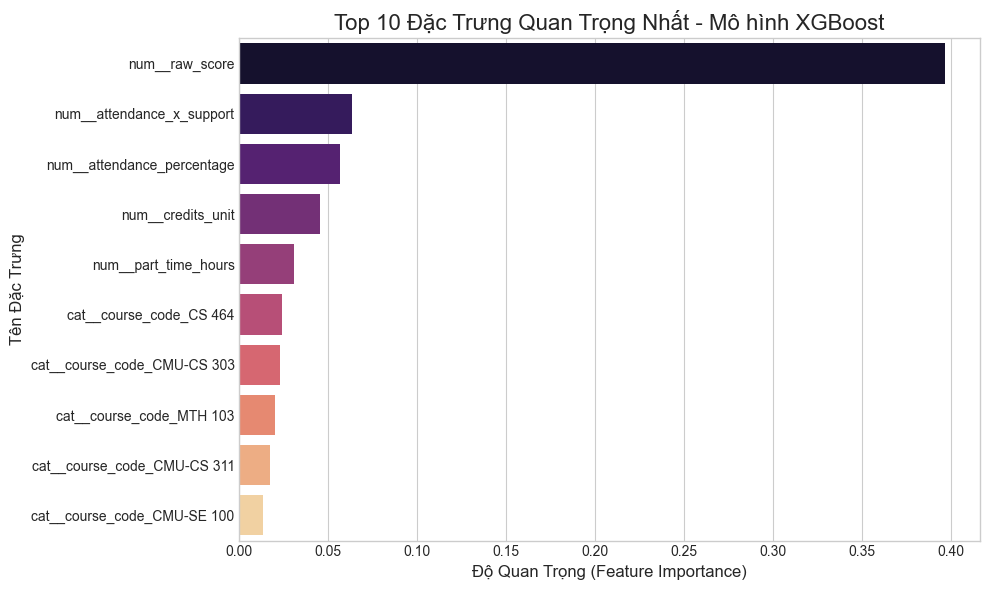

In [10]:
# === PH·∫¶N 6: TOP 10 ƒê·∫∂C TR∆ØNG QUAN TR·ªåNG NH·∫§T C·ª¶A XGBOOST ===
importances = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hi·ªÉn th·ªã b·∫£ng
print("\n--- üîç Top 10 ƒë·∫∑c tr∆∞ng quan tr·ªçng nh·∫•t c·ªßa m√¥ h√¨nh XGBoost ---")
display(top_features.style.format({"Importance": "{:.4f}"}))

# Bi·ªÉu ƒë·ªì tr·ª±c quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='magma')
plt.title('Top 10 ƒê·∫∑c Tr∆∞ng Quan Tr·ªçng Nh·∫•t - M√¥ h√¨nh XGBoost', fontsize=16)
plt.xlabel('ƒê·ªô Quan Tr·ªçng (Feature Importance)', fontsize=12)
plt.ylabel('T√™n ƒê·∫∑c Tr∆∞ng', fontsize=12)
plt.tight_layout()
plt.savefig('XGBoostPermutationImportancev1.png')
plt.show()



--- üîç T√≠nh Permutation Importance cho MLPRegressor ---
--- üîç Top 10 ƒë·∫∑c tr∆∞ng quan tr·ªçng nh·∫•t c·ªßa m√¥ h√¨nh MLPRegressor ---


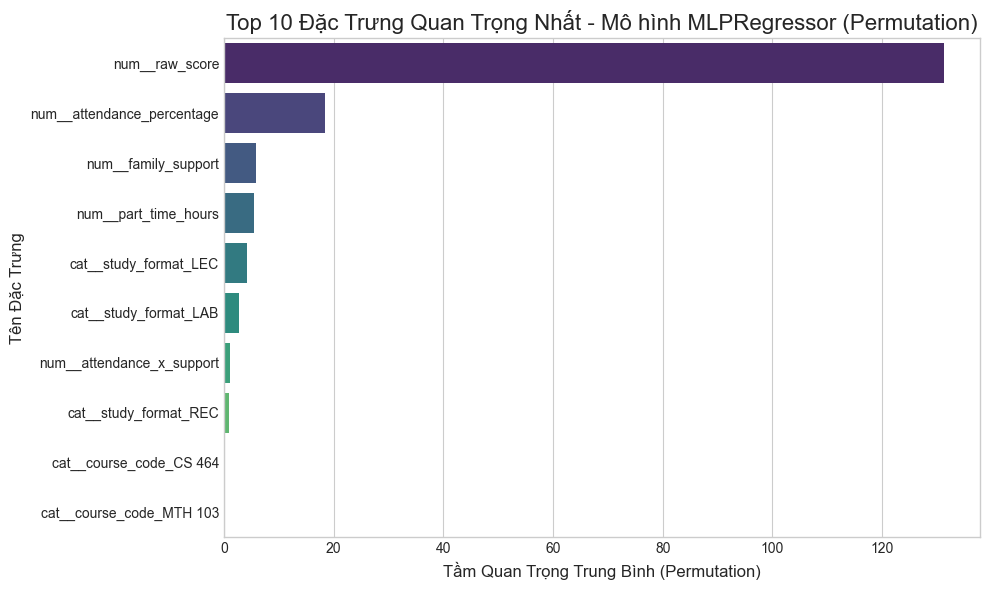

In [11]:
from sklearn.inspection import permutation_importance

# T√≠nh Permutation Importance tr√™n t·∫≠p ki·ªÉm tra
print("\n--- üîç T√≠nh Permutation Importance cho MLPRegressor ---")
perm_result = permutation_importance(
    best_mlp_model, X_test, y_test, n_repeats=10,
    random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)

# L∆∞u l·∫°i k·∫øt qu·∫£ d∆∞·ªõi d·∫°ng DataFrame
mlp_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_result.importances_mean
})
top_mlp_features = mlp_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hi·ªÉn th·ªã b·∫£ng
print("--- üîç Top 10 ƒë·∫∑c tr∆∞ng quan tr·ªçng nh·∫•t c·ªßa m√¥ h√¨nh MLPRegressor ---")
display(top_mlp_features.style.format({"Importance": "{:.4f}"}))

# Bi·ªÉu ƒë·ªì tr·ª±c quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_mlp_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 ƒê·∫∑c Tr∆∞ng Quan Tr·ªçng Nh·∫•t - M√¥ h√¨nh MLPRegressor (Permutation)', fontsize=16)
plt.xlabel('T·∫ßm Quan Tr·ªçng Trung B√¨nh (Permutation)', fontsize=12)
plt.ylabel('T√™n ƒê·∫∑c Tr∆∞ng', fontsize=12)
plt.tight_layout()
plt.savefig('MLPRegressorPermutationImportancev1.png')
plt.show()
